In [142]:
from astropy.io import fits
import numpy as np
import sys
sys.path.append("/Users/savard/PLUTO/pluto_playtime/plotting_analysis/")
from pyplutplot import * 
from fits_conversion import *

import aplpy
import os
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy import units as u
from astropy.coordinates import SkyCoord

In [143]:
system_name = 'ri0.001_rb0.02_lz2'
data_dir = '/pluto_playtime/data_storage/'+system_name+'/' #set up working directory where data is stored
results_folder = '/Users/savard/PLUTO/pluto_playtime/plotting_analysis/sim_results/{}'.format(system_name)
eht_results_folder = '/Users/savard/PLUTO/pluto_playtime/plotting_analysis/sim_results/eht_scaled_sims'

In [160]:
kappa = 0.1 #fraction of pressure contribution to luminosity
gamma = 2.0
image_timestep = 50
#L_sim = 1*10**13 #m
L_sim = 465841907.0462244 #m
nu_observe = (86.0 * 1e9) #1.28 GHz (Bright2020)
distance_in_pc = 2960

In [161]:
ez_filename = 'pixel_lum_'+system_name+'_'+str(image_timestep)+'_'+str(nu_observe/1e9)+'GHz'
#image_array = load_list(results_folder,ez_filename)
image_array = load_list(eht_results_folder,ez_filename)
image_array_flip = np.concatenate((np.flip(image_array,axis=1),np.array(image_array)),axis=1)

In [162]:
print(np.shape(image_array_flip))
#check if needs a deres
image_array_flip = deres_array_check(image_array_flip)

#check if the shape is even
image_array_flip = even_shape_check(image_array_flip)

print(np.shape(image_array_flip))

(1300, 1300)
square elements, no need to de-res
image has even sides, no need to adjust
(1300, 1300)


In [163]:
def unit_print(D,image,L_sim):
    #now check what the resolution size is in real units for wsclean:
    ax1_check = D.x1[:len(image[0])]
    ax2_check = D.x2[:len(image.T[0])]
    x = m_to_arcseconds(ax1_check*L_sim,distance_in_pc)
    y = m_to_arcseconds(ax2_check*L_sim,distance_in_pc)
    xres = x[2]-x[1]
    yres = y[2]-y[1]
    print('x-direction res: {:.8f} arcseconds'.format(xres))
    print('y-direction res: {:.8f} arcseconds'.format(yres))
    return xres/3600,yres/3600

In [164]:
D = load_data_obj(data_dir,image_timestep,data_type='flt')
xres, yres = unit_print(D,image_array,L_sim)
print(xres)

data type: flt
Reading multiple variable files : /Users/savard/PLUTO/pluto_playtime/data_storage/ri0.001_rb0.02_lz2/rho.0050.flt
Reading multiple variable files : /Users/savard/PLUTO/pluto_playtime/data_storage/ri0.001_rb0.02_lz2/vx1.0050.flt
Reading multiple variable files : /Users/savard/PLUTO/pluto_playtime/data_storage/ri0.001_rb0.02_lz2/vx2.0050.flt
Reading multiple variable files : /Users/savard/PLUTO/pluto_playtime/data_storage/ri0.001_rb0.02_lz2/vx3.0050.flt
Reading multiple variable files : /Users/savard/PLUTO/pluto_playtime/data_storage/ri0.001_rb0.02_lz2/prs.0050.flt
Reading multiple variable files : /Users/savard/PLUTO/pluto_playtime/data_storage/ri0.001_rb0.02_lz2/tr1.0050.flt
Reading multiple variable files : /Users/savard/PLUTO/pluto_playtime/data_storage/ri0.001_rb0.02_lz2/tr2.0050.flt
x-direction res: 0.00000018 arcseconds
y-direction res: 0.00000018 arcseconds
4.870364881991969e-11


In [165]:
def plot_image(D,image_array,L_sim,scalebar_unit,scalebar_label):
    ax1 = D.x1[:len(image_array[0])]
    ax2 = D.x2[:len(image_array.T[0])]
    scale = len(ax2)/(len(ax1)*2)

    fig, ax = plt.subplots(1,1,figsize=(9*scale,9))

    x = m_to_arcseconds(ax1*L_sim,distance_in_pc)
    y = m_to_arcseconds(ax2*L_sim,distance_in_pc)

    scale = len(ax2)/(len(ax1)*2)

    p = ax.pcolormesh(x,y,(image_array),cmap='afmhot',shading='auto')
    ax.pcolormesh(-x,y,(image_array),cmap='afmhot',shading='auto')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="10%", pad=0.3)
    cbar = plt.colorbar(p,cax=cax)
    cbar.set_label('Jy per pixel')

    
    frame_flux = np.sum(image_array*10**3)*2
    s = 20e-6 #scalebar_unit
    
    scalebar = AnchoredSizeBar(ax.transData, s, scalebar_label,9,color='white',frameon=False,size_vertical=s*0.001,pad=1,sep=3)

    ax.add_artist(scalebar)

    ax.set_title('total flux in image: {:.8f} mJy'.format(frame_flux))
    ax.set_xlabel('size in arcseconds')
    ax.set_aspect('equal', adjustable='box')

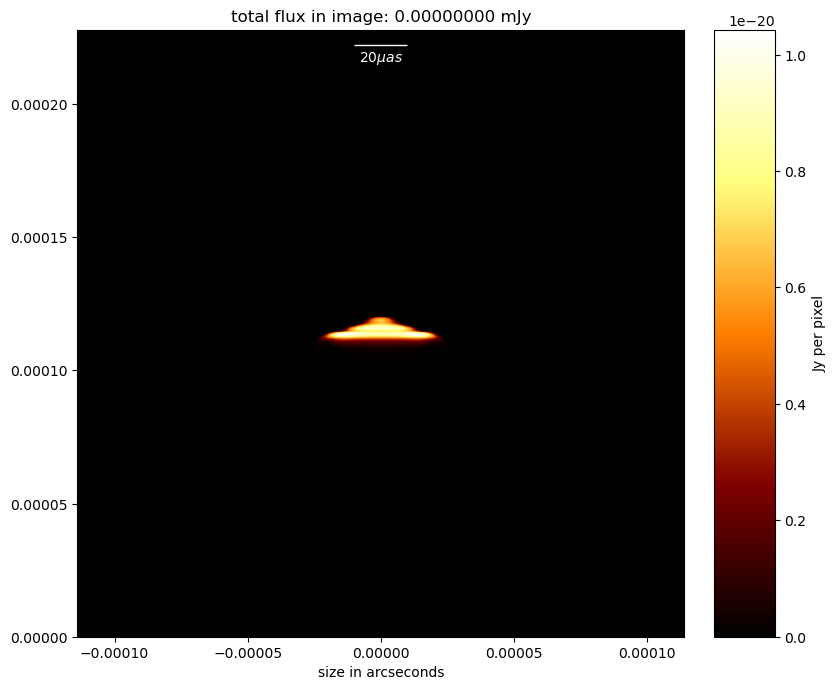

In [166]:
plot_image(D,image_array,L_sim,0.5,r"$20\mu as$")

saving new figure!!


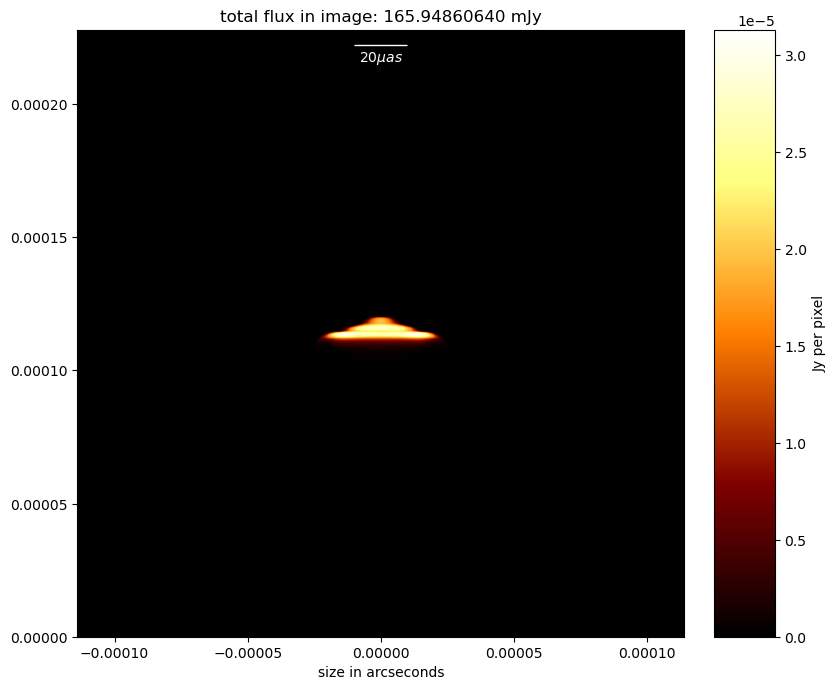

In [167]:
lum_scaler = 3e15
eht_image_array = image_array*lum_scaler

length_scaler = 1
plot_image(D,eht_image_array,L_sim*length_scaler,20e-6,r'$20\mu as$')


xres_eht = xres*length_scaler
yres_eht = yres*length_scaler
save_fig(results_folder,'maxi1820_{}days_EHTscaled'.format(image_timestep),overwrite=True)

In [192]:
eht_image_array_flip = np.concatenate((np.flip(eht_image_array,axis=1),np.array(eht_image_array)),axis=1)


hdu = fits.PrimaryHDU(eht_image_array_flip)
fits_name = 'ffile_'+system_name+'_'+str(image_timestep)

exta_descriptors='_EHTscaled'

eht_fits = results_folder+'/'+fits_name+exta_descriptors+'.fits'


now find out where in time and distance the center should be:

In [193]:
write_new = True

if write_new:
    hdu.writeto(eht_fits,overwrite=True)
    hdul = fits.open(eht_fits,mode='update')
    hdu = hdul[0]
    headers = hdu.header
    headers = hdu.header
    cent_pix1 = len(image_array_flip[0])/2
    cent_pix2 = len(image_array_flip.T[0])/2
    headers.set('BUNIT','JY/PIXEL')
    headers.set('BSCALE',1.)
    headers.set('BZERO',0.)
    headers.set('BTYPE','Intensity')
    headers.set('CRPIX1',cent_pix1)
    headers.set('CRPIX2',cent_pix2)
    headers.set('CUNIT1','deg     ')
    headers.set('CUNIT2','deg     ')

    headers.set('CRVAL1',-84.9085916666667)
    headers.set('CRVAL2',7.18532694444445)

    headers.set('CTYPE1','RA---SIN')
    headers.comments['CTYPE1'] = 'Right ascension angle cosine'
    headers.set('CTYPE2','DEC--SIN')
    headers.comments['CTYPE2'] = 'Declination angle cosine'
    headers.set('CDELT1',xres_eht)
    headers.set('CDELT2',yres_eht)
    hdul.flush()

In [194]:
hdul = fits.open(eht_fits,mode='readonly')
hdu = hdul[0]
headers = hdu.header
headers

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -64 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                 1300                                                  
NAXIS2  =                 1300                                                  
EXTEND  =                    T                                                  
BUNIT   = 'JY/PIXEL'                                                            
BSCALE  =                  1.0                                                  
BZERO   =                  0.0                                                  
BTYPE   = 'Intensity'                                                           
CRPIX1  =                650.0                                                  
CRPIX2  =                650.0                                                  
CUNIT1  = 'deg     '        

In [195]:
np.sum(hdu.data)

0.1659486063981976

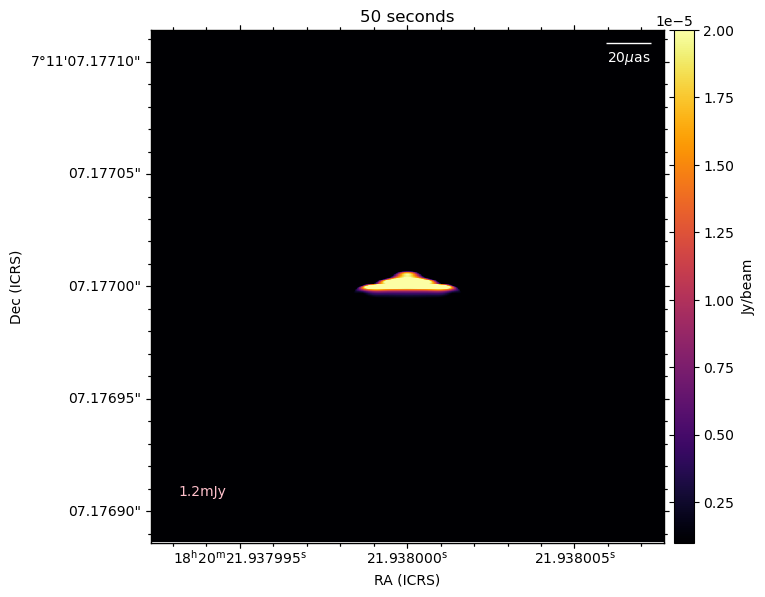

In [208]:
fig = plt.figure(figsize=(7, 7))
f1 = aplpy.FITSFigure(eht_fits,figure=fig)
f1.show_colorscale(cmap='inferno',vmin=1e-6,vmax=2e-5)
f1.add_colorbar()
f1.colorbar.show(pad=0.1)
f1.colorbar.set_location('right')
f1.colorbar.set_axis_label_text('Jy/beam')
f1.add_scalebar(20*1e-6 * u.arcsecond)
f1.scalebar.set_corner('top right')
f1.scalebar.set_color('white')
f1.scalebar.set_label(r'20$\mu$as')
f1.add_label(x=0.1,y=0.1,text='1.2mJy',relative=True,color='pink')
f1.set_title('{} seconds'.format(image_timestep))

In [173]:
ra_core_deg = -84.9085916666667
dec_core_deg = 7.18532694444445

c1 = SkyCoord(ra_core_deg,dec_core_deg,unit=(u.deg, u.deg),frame='icrs')
position_angle = 155 * u.deg# 155

In [174]:
disp_current = rel_d_arcsecond_com_scaled[image_timestep]

In [190]:
c1.ra.degree

275.09140833333333

In [187]:
separation = (disp_current) * u.microarcsecond #degrees
new_pos = c1.directional_offset_by(position_angle, separation)
new_pos

<SkyCoord (ICRS): (ra, dec) in deg
    (275.09140835, 7.18532691)>

time

In [23]:
def tstep_to_days(t,dbl_step):
    """converts simulation steps into days.
    assumes a fixed simulation time unit writing a step every multiple of dbl_step
    """
    T_SIM_YEARS = 1.05*10**(-3)
    d = t*T_SIM_YEARS*365*dbl_step
    return d
def calc_betas_COM(displacement_values,timestep,initial_gamma):
    """Needs displacement values in units of centimeters!!
    """
    initial_beta = gamma_to_beta(initial_gamma)
    beta_list = [initial_beta]
    d_prev = displacement_values[0]
    for d in displacement_values[1:]:
        beta = ((d-d_prev)/timestep)/(2.998*10**10) #v/c in cm/s
        beta_list.append(beta)
        d_prev = np.copy(d)
    beta_list = np.asarray(beta_list)
    return beta_list

def geometric_delta(angle,beta):
    #calculates doppler boost factor delta, given an angle to line of sight and intrinsic beta. 
    
    #change minus sign for approaching (-) or receding (+) jet
    delta = (1.0-beta*np.cos(angle))**(-1)
    return delta #THIS HAS THE ^-1 SO YOU DIVIDE REST FRAME VALUES BY THIS 

def doppler_time(time_array,angle,beta_array):
    delta_array = geometric_delta(angle,beta_array) #used to use angle_to_boost() which is the relativistic correction
    cumulative_time_restframe = 0
    cumulative_time_obsframe = 0
    time_array_obsframe = []
    for index, t in enumerate(time_array):
        timestep_restframe = t-cumulative_time_restframe
        timestep_obsframe = timestep_restframe/delta_array[index]
        #print(timestep_obsframe)
        cumulative_time_obsframe = cumulative_time_obsframe + timestep_obsframe
        cumulative_time_restframe = cumulative_time_restframe+timestep_restframe
        time_array_obsframe.append(cumulative_time_obsframe)
    return time_array_obsframe
    
def cal_beta_app(beta,angle,approaching=True):
    num = beta*np.sin(angle)
    if approaching:
        denom = 1. - beta*np.cos(angle)
    else:
        denom = 1. + beta*np.cos(angle)
    beta_app = num/denom 
    return beta_app
def calc_displacement(speeds,time,simunits=True):
    """
    simunits = True -> returns in simulation units
    simunits = False -> returns in cm 
    """
    distance = []
    for index, s in enumerate(speeds):
        if index==0:
            curr = 0
        else:
            dt = time[index]-time[index-1]
            if simunits:
                disp = s*dt
            else:
                disp = s*dt*86400*(2.998*10**10)
            curr = distance[index-1]+disp
        distance.append(curr)
    return distance


In [22]:
gamma = 2.0
dbl_step = 4
def theta_from_beta(beta):
    theta = np.arccos(0.4/beta)*180/np.pi
    return theta
def gamma_to_beta(gamma):
    beta = (1.-(gamma**-2))**0.5
    return beta
angle_degrees = theta_from_beta(gamma_to_beta(gamma))
viewing_angle = (2*np.pi)/360 *angle_degrees

In [50]:
file_disp = 'disp_array'+str(system_name)
d_vals = load_list(results_folder,file_disp)
d_arcsecond = (np.array(d_vals)*(10**15))/(1.496*10**(13))*(1/distance_in_pc) #convert to arcseconds at 3kps (sim units to cm, to AU, to arcseconds)
distance_in_cm = d_vals*10**15 #in cm 

In [51]:
time = tstep_to_days(np.arange(0,len(d_vals),1),dbl_step=dbl_step) #time in days
timestep = (time[2]-time[1])*86400 #in seconds
beta_com_list = calc_betas_COM(distance_in_cm,timestep,initial_gamma=gamma)
time_obsframe_com = doppler_time(time,viewing_angle,np.asarray(beta_com_list))

In [52]:
beta_apparents_com = cal_beta_app(np.asarray(beta_com_list),viewing_angle)
rel_d_com = calc_displacement(beta_apparents_com,time_obsframe_com,simunits=False) #in sim units
rel_d_arcsecond_com = (np.array(rel_d_com)/(1.496*10**(13))) * (1/distance_in_pc) #convert to arcseconds at 3kpc

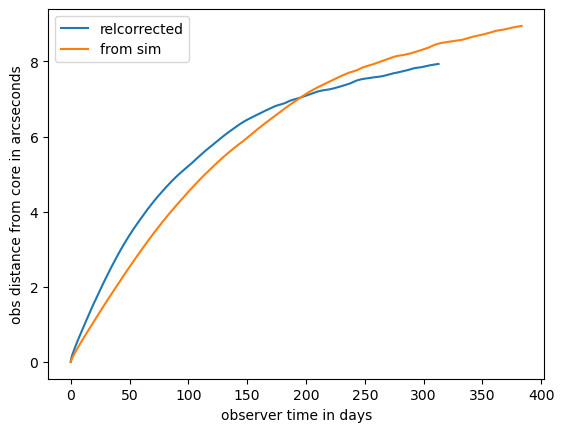

In [54]:
plt.plot(time_obsframe_com,rel_d_arcsecond_com,label='relcorrected')
plt.plot(time,d_arcsecond,label='from sim')
plt.xlabel('observer time in days')
plt.ylabel('obs distance from core in arcseconds')
plt.legend()

Now scale it down:

In [29]:
unit_length_1820 = (44*10**10)/9.5058
c = 2.998*10**(10) #cm/s
unit_time_1820 = unit_length_1820/c

In [30]:
def code_to_uas(x,unit_L,distance):
    AU_in_cm = 1.496*10**13
    x_cm = x*unit_L
    x_AU = x_cm/AU_in_cm
    x_asec = x_AU/distance
    x_uas = x_asec*10**6
    return x_uas

In [57]:
rel_d_arcsecond_com_scaled = code_to_uas(np.asarray(rel_d_com)/(10**15),unit_length_1820,distance_in_pc)
d_scaled = (np.array(d_vals)*unit_length_1820) 
d_uarcsecond_scaled = code_to_uas(d_vals,unit_length_1820,distance_in_pc)

In [32]:
def tstep_to_seconds(t,dbl_step,unit_time):
    return t*dbl_step*unit_time

In [33]:
t_sec_scaled = tstep_to_seconds(np.arange(0,len(d_vals),1),4,unit_time_1820)
timestep_scaled = unit_time_1820*dbl_step#t_sec_scaled[2]-t_sec_scaled[1]
beta_com_list_scaled = calc_betas_COM(d_vals*unit_length_1820,timestep_scaled,initial_gamma=gamma)
time_obsframe_com_scaled = doppler_time(t_sec_scaled,viewing_angle,np.asarray(beta_com_list_scaled))

In [169]:
save_list(time_obsframe_com_scaled,eht_results_folder,'timearray_projected_scaled')
save_list(rel_d_arcsecond_com_scaled,eht_results_folder,'disparray_projected_scaled')

Overwriting existing figure!!!


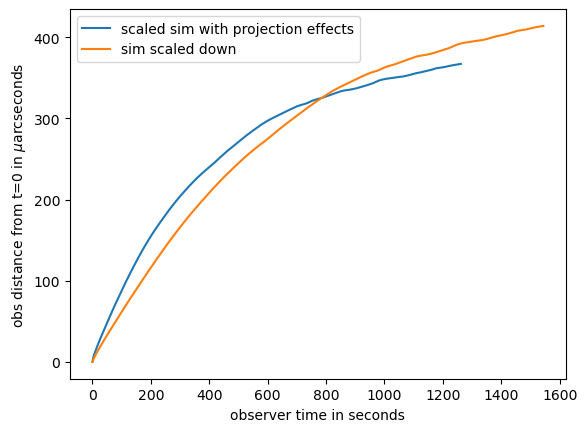

In [74]:
plt.plot(np.asarray(time_obsframe_com_scaled),rel_d_arcsecond_com_scaled,label='scaled sim with projection effects')
#plt.plot(t_sec_scaled,rel_d_arcsecond_com_scaled,label='no time dilation')
plt.plot(np.asarray(t_sec_scaled),d_uarcsecond_scaled,label='sim scaled down')
#plt.plot(t_sec_scaled,rel_d_com,label='no length')
plt.xlabel('observer time in seconds')
plt.ylabel(r'obs distance from t=0 in $\mu$arcseconds')
plt.legend()
save_fig(eht_results_folder,'scaled_sim_deceleration_seconds',overwrite=True)

In [210]:
x = [20,30,40,50,60,70,80,90,100]
for t in x:
    print(np.asarray(time_obsframe_com_scaled)[t])

72.42086367300826
111.1856224265878
151.20726403271505
192.79614192524787
236.4631355971915
281.5075824581728
328.28703732678025
376.7340312102663
426.3921280909445


Overwriting existing figure!!!


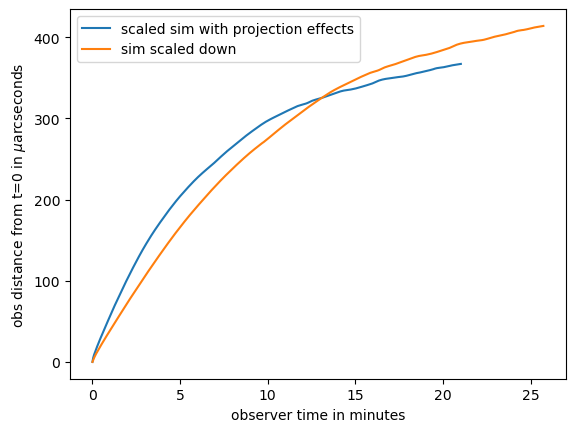

In [75]:
plt.plot(np.asarray(time_obsframe_com_scaled)/60.0,rel_d_arcsecond_com_scaled,label='scaled sim with projection effects')
#plt.plot(t_sec_scaled,rel_d_arcsecond_com_scaled,label='no time dilation')
plt.plot(np.asarray(t_sec_scaled)/60,d_uarcsecond_scaled,label='sim scaled down')
#plt.plot(t_sec_scaled,rel_d_com,label='no length')
plt.xlabel('observer time in minutes')
plt.ylabel(r'obs distance from t=0 in $\mu$arcseconds')
plt.legend()
save_fig(eht_results_folder,'scaled_sim_deceleration_minutes',overwrite=True)